## 1. K-NN classifier

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

NUM_ATTRIBUTES = 11
HIGH_QUALITY = 1
LOW_QUALITY = 0

# Initialise training and testing data into Dataframes
train_data = pd.read_csv('winequality-train.csv')
test_data = pd.read_csv('winequality-test.csv')

def find_euclidean_dist(train_attributes, point):
    """Calculate Euclidean distances between a single instance (point) and all instances 
    in a training data set"""
    # Note: For efficiency use vectorised operations to avoid for loop
    return np.sqrt(np.sum((train_attributes - point) ** 2, axis=1))

def classify_point(train_attributes, train_label, point, k):
    """Classifies a point, according to a chosen k, using KNN with majority vote to choose the label, 
    also tie-breaks by taking the label of 1-NN"""
    # Get euclidian distances between the attributes of training data and test instance
    distances = find_euclidean_dist(train_attributes, point)

    # Sort distances and get index list of k nearest neighbours
    distances = np.argsort(distances)
    nearest_idx = distances[:k]

    # Get the information for each nearest neighbour
    nearest_neighbours = [(index, distance, labels) for index, distance, labels 
                          in zip(nearest_idx, 
                                 distances[nearest_idx], 
                                 train_label.iloc[nearest_idx])]

    # Find the counts for each label from the nearest neighbours
    label_count = Counter([neighbour[2] for neighbour in nearest_neighbours])
    num_low_quality = label_count[LOW_QUALITY]
    num_high_quality = label_count[HIGH_QUALITY]
    
    # Find the predicted class
    if num_low_quality > num_high_quality:
        return LOW_QUALITY
    elif num_high_quality > num_low_quality:
        return HIGH_QUALITY
    # If there is a tie return the label of the 1-NN
    else:
        # Note: as defined previously, the 2nd index for each tuple is the label of the train_instance
        # so this will find the label of the 1-NN
        return nearest_neighbours[0][2]

def knn_classifier(train_data, test_data, k, export_filename):
    """Takes training data set and testing data set then uses KNN to classify 
    the instances in the test data set based on k and euclidean distance, 
    returns a dataframe showing the index of the test instance and its predicted 
    label, this dataframe is also exported as a csv file"""
    # Initialise the attributes and label dataframes
    train_attributes = train_data.iloc[:,:NUM_ATTRIBUTES]
    train_label = train_data.iloc[:,-1]
    test_attributes = test_data.iloc[:,:NUM_ATTRIBUTES]

    # Initialise the list of predicted labels
    predicted_labels = []
    # Iterate through each test instance and predict its label
    for test_instance in range(len(test_attributes)):
        predicted_labels.append((test_instance, classify_point(train_attributes, 
                                train_label, test_attributes.iloc[test_instance], k)))
    
    predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Instance', 'Predicted_Label'])

    predicted_labels_df.to_csv(f'knn_results/{export_filename}', index=False)

    return predicted_labels_df 


## 2. 1-NN classification

In [12]:
def calculate_accuracy(actual_labels, predicted_labels):
    """Takes the actual labels and predicted labels of the test data and returns its accuracy"""
    return np.mean(actual_labels.values == predicted_labels.values)

In [13]:
# Run the KNN classifer with k=1; 1NN
predicted_labels_df = knn_classifier(train_data, test_data, k=1, export_filename='1NN_results.csv')

# Print the accuracy of the 1-NN classification
accuracy = calculate_accuracy(test_data['quality'], predicted_labels_df['Predicted_Label'])
print(f'Accuracy = {accuracy}')

Accuracy = 0.7644444444444445


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_pairplot(train_data, plot_title, export_filename, hue='quality', num_samples=200):
    """Takes and plots a pairplot between attributes of alcohol, fixedAcidity, 
    residualSugar and density, the plots show the classfications of quality. 
    Function then shows the plot and exports the plot png"""
    # Select random subset of data using the attributes
    subset_data = train_data[['alcohol', 'fixedAcidity', 'residualSugar', 'density', 'quality']].sample(num_samples, random_state=42)

    # Construct pairplot
    plot = sns.pairplot(subset_data, hue=hue, palette={LOW_QUALITY: sns.color_palette('muted')[0],
                                                HIGH_QUALITY: sns.color_palette('muted')[1]}, 
                 hue_order=[LOW_QUALITY, HIGH_QUALITY], 
                 )
    
    plot.figure.suptitle(f'{plot_title}', y=1.02)

    # Construct proper legend
    plot._legend.set_title('Quality')
    legend_labels = ['Low Quality', 'High Quality']
    for t, l in zip(plot._legend.texts, legend_labels):
        t.set_text(l)
    plot._legend.set_bbox_to_anchor((1.08, 0.5))
    plot.savefig(f'pairwise_plots/{export_filename}')
    plt.show()

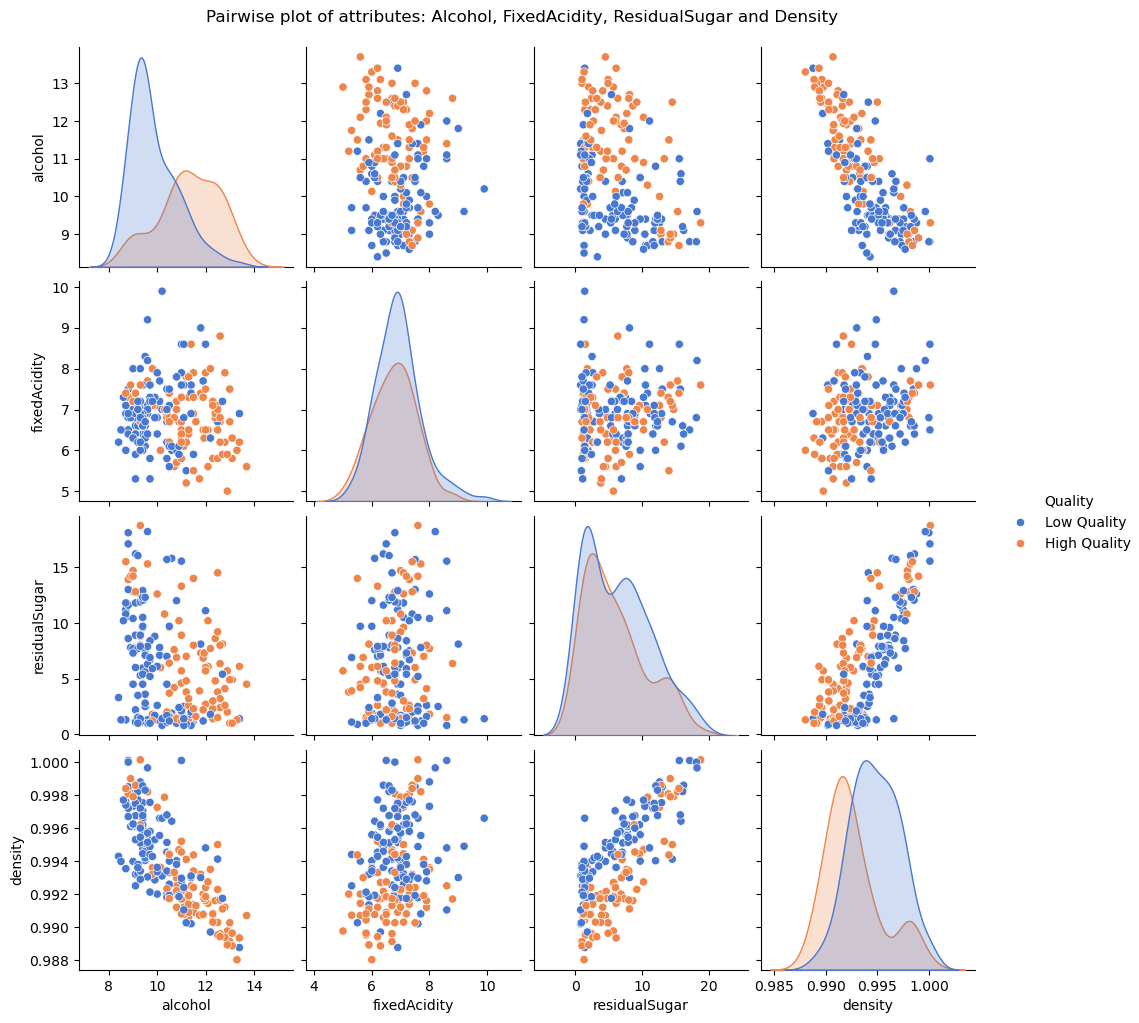

In [5]:
# Plot the pairs of attributes, density, residualSugar, fixedAcidity and Alcohol
create_pairplot(train_data, plot_title="Pairwise plot of attributes: Alcohol, FixedAcidity, \
ResidualSugar and Density", export_filename='default_data_pairplot.png')

## 3. Normalization

In [15]:
def min_max_normalisation(data):
    """Takes a dataframe of data and min-max normalises all of the attributes,
    returns a dataframe with the min-max normalised data"""
    # Make a copy to not modify original data
    normalized_df = data.copy()

    # Min-max scale all of the attributes by iterating over the attribute columns
    for attribute in normalized_df.columns[:NUM_ATTRIBUTES]:
        # Find min and max values
        min_val = normalized_df[attribute].min()
        max_val = normalized_df[attribute].max()

        # Do min-max normalisation on the column (attribute)
        normalized_df[attribute] = (normalized_df[attribute] - min_val) / (max_val - min_val)
    
    return normalized_df

def standardise_attributes(data):
    """Takes a dataframe of data and standardises all of the attributes, returns
    a dataframe with the standardised data"""
    standardised_df = data.copy()
    
    # Standardise all attributes by iterating over the attribute columns
    for attribute in standardised_df.columns[:NUM_ATTRIBUTES]:
         # Find mean and standard deviation
        mean_val = np.mean(standardised_df[attribute])
        std_val = np.std(standardised_df[attribute])

        # Standardise the attributes
        standardised_df[attribute] = (standardised_df[attribute] - mean_val) / std_val

    return standardised_df


In [18]:
# Get both min-max normalised and standardised data
min_max_scaled_train = min_max_normalisation(train_data)
min_max_scaled_test = min_max_normalisation(test_data)

standardised_train = standardise_attributes(train_data)
standardised_test = standardise_attributes(test_data)

# Run 1NN with these normalised datasets
predicted_min_max_labels_df = knn_classifier(min_max_scaled_train, min_max_scaled_test, k=1, export_filename='1NN_min_max.csv')
predicted_standardised_labels_df = knn_classifier(standardised_train, standardised_test, k=1, export_filename='1NN_standardised.csv')

# Calculate the accuracy of the 1NN run with these normalised datasets
min_max_accuracy = calculate_accuracy(min_max_scaled_test['quality'], predicted_min_max_labels_df['Predicted_Label'])
standardised_accuracy = calculate_accuracy(standardised_test['quality'], predicted_standardised_labels_df['Predicted_Label'])

# Print the accuracy of the min-max normalised and standardised data
print(f'Min-max normalisation accuracy: {min_max_accuracy}')
print(f'Standardisation accuracy: {standardised_accuracy}')

fixedAcidity
volatileAcidity
citricAcid
residualSugar
chlorides
freeSulfurDioxide
totalSulfurDioxide
density
pH
sulphates
alcohol
fixedAcidity
volatileAcidity
citricAcid
residualSugar
chlorides
freeSulfurDioxide
totalSulfurDioxide
density
pH
sulphates
alcohol
Min-max normalisation accuracy: 0.8348148148148148
Standardisation accuracy: 0.8622222222222222


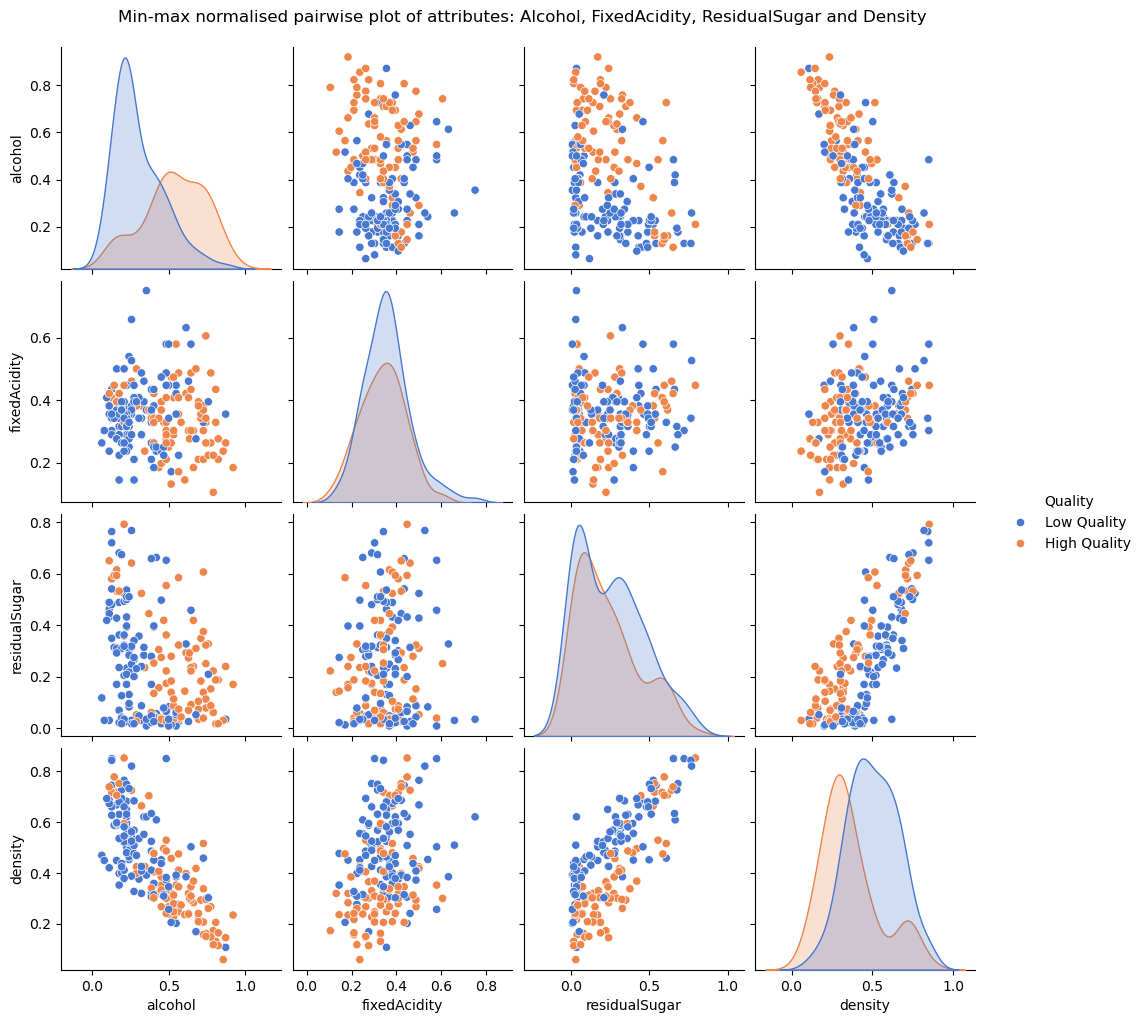

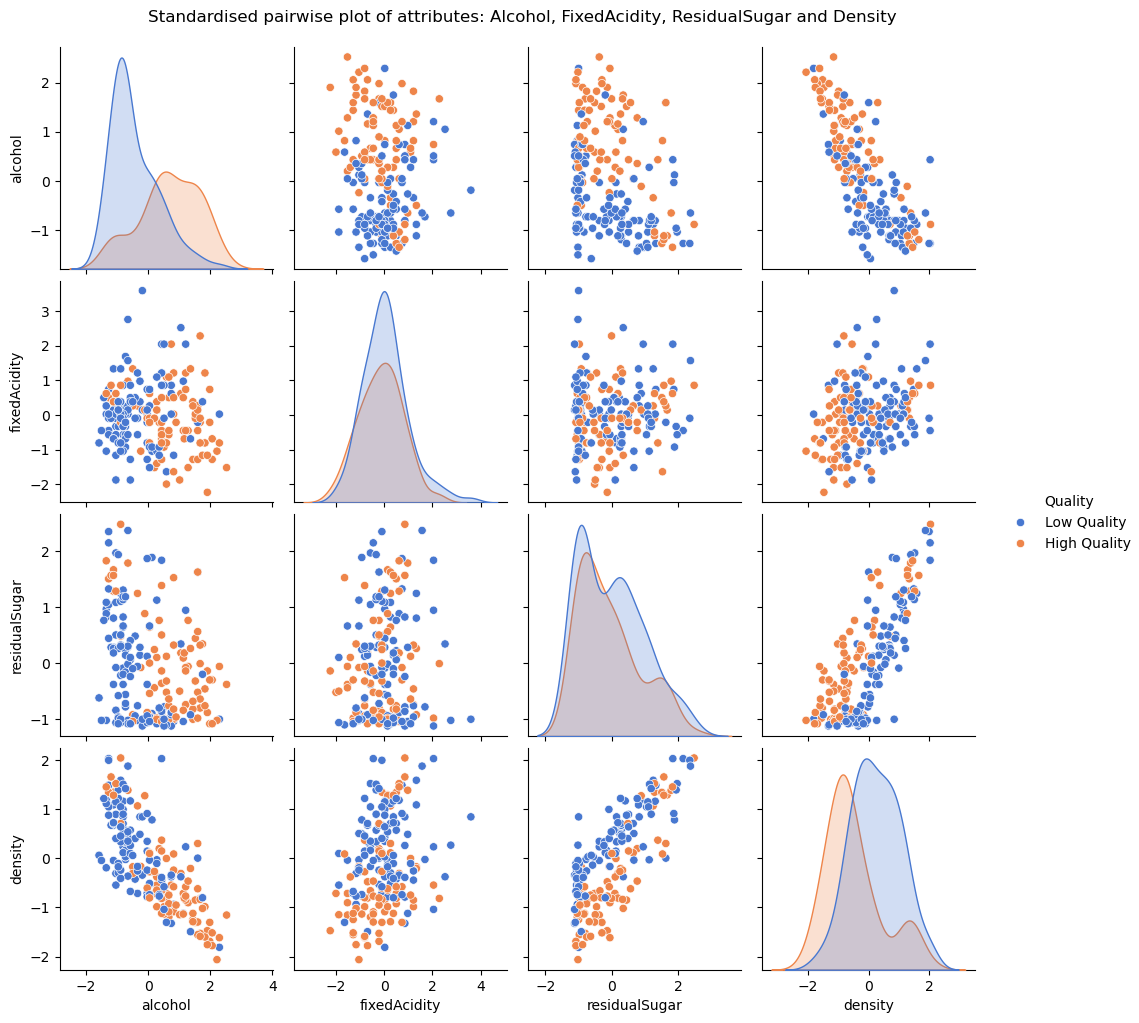

In [8]:
# Plot the pairs of attributes, density, residualSugar, fixedAcidity and Alcohol
# for the min-max normalised data and the standardised data
create_pairplot(min_max_scaled_train, plot_title="Min-max normalised pairwise plot of attributes: \
Alcohol, FixedAcidity, ResidualSugar and Density", export_filename='min_max_data_pairplot.png')

create_pairplot(standardised_train, plot_title="Standardised pairwise plot of attributes: Alcohol, FixedAcidity, \
ResidualSugar and Density", export_filename='standardised_data_pairplot.png')

## 4. Model extensions

### 4.2
Implemented two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance 

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_mahalanobis_dist(train_attributes, point, inv_covariance_matrix):
    """Calculate mahalanobis distance between a single instance (point) and all instances 
    in a training data set"""
    # Apply the mahalanobis distance formula
    # Note: Didn't use the library functions as to avoid for loop, instead use vectorised operations
    difference = train_attributes - point
    return np.sqrt(np.sum(np.dot(difference, inv_covariance_matrix) * difference, axis=1))

def find_cosine_similarity(train_attributes, point):
    """Calculate cosine similarity between a single instance (point) and all instances 
    in a training data set using sklearn"""
    return cosine_similarity([point], train_attributes).ravel()

def classify_point_choose_dist_measure(train_attributes, train_label, point, k, distance_measure):
    """Classifies a point, according to a chosen k, using KNN with majority vote to choose the label, 
    also tie-breaks by taking the label of 1-NN"""

    # Determine which distance measure we are using
    if distance_measure == "Cosine Similarity":
        distances = find_cosine_similarity(train_attributes, point)
    elif distance_measure == "Mahalanobis Distance":
        # Note: Rowvar is False as the rows are our instances and columns are attributes
        covariance_matrix = np.cov(train_attributes, rowvar=False)
        distances = find_mahalanobis_dist(train_attributes, point, np.linalg.inv(covariance_matrix))

    # Sort distances and get index list of k nearest neighbours
    distances = np.argsort(distances)
    nearest_idx = distances[:k]

    # Get the information for each nearest neighbour
    nearest_neighbours = [(index, distance, labels) for index, distance, labels 
                          in zip(nearest_idx, distances[nearest_idx], train_label.iloc[nearest_idx])]

    # Find the counts for each label from the nearest neighbours
    label_count = Counter([neighbour[2] for neighbour in nearest_neighbours])
    num_low_quality = label_count[LOW_QUALITY]
    num_high_quality = label_count[HIGH_QUALITY]
    
    # Find the predicted class
    if num_low_quality > num_high_quality:
        return LOW_QUALITY
    elif num_high_quality > num_low_quality:
        return HIGH_QUALITY
    # If there is a tie return the label of the 1-NN
    else:
        # Note: as defined previously, the 2nd index for each tuple is the label of the train_instance
        return nearest_neighbours[0][2]

def knn_choose_dist_measure(train_data, test_data, k, export_filename, distance_measure):
    """Takes training data set, testing data set then uses KNN to classify the instances 
    in the test data set, returns a list of tuples with each tuple showing the index of the
    test instance and its predicted label"""
    # Remove the label from the test data
    train_attributes = train_data.iloc[:,:NUM_ATTRIBUTES]
    train_label = train_data.iloc[:,-1]
    test_attributes = test_data.iloc[:,:NUM_ATTRIBUTES]

    # Initialise the list of predicted labels
    predicted_labels = []
    for test_instance in range(len(test_attributes)):
        predicted_labels.append((test_instance, classify_point_choose_dist_measure(train_attributes, train_label, test_attributes.iloc[test_instance], k, distance_measure)))
    
    predicted_labels_df = pd.DataFrame(predicted_labels, columns=['Instance', 'Predicted_Label'])

    predicted_labels_df.to_csv(f'knn_results/{export_filename}', index=False)

    return predicted_labels_df 

In [10]:
# Perform 1NN with distance measures of cosine similarity and mahalanobis distance
# For each distance measure use non-normalised data, min-max normalised data and standardised data
cosine_predicted_labels = knn_choose_dist_measure(train_data, test_data, k=1,
                                                  export_filename='Cosine_1NN_results.csv',
                                                  distance_measure="Cosine Similarity")

cosine_predicted_min_max = knn_choose_dist_measure(min_max_scaled_train, min_max_scaled_test, k=1, 
                                                   export_filename='Cosine_1NN_min_max.csv', 
                                                   distance_measure="Cosine Similarity")

cosine_predicted_standardised = knn_choose_dist_measure(standardised_train, standardised_test, k=1, 
                                                        export_filename='Cosine_1NN_standardised.csv',
                                                        distance_measure="Cosine Similarity")

mahalanobis_predicted_labels = knn_choose_dist_measure(train_data, test_data, k=1,
                                                       export_filename='Mahalanobis_1NN_results.csv', 
                                                       distance_measure="Mahalanobis Distance")

mahalanobis_predicted_min_max = knn_choose_dist_measure(min_max_scaled_train, min_max_scaled_test, k=1, 
                                                        export_filename='Mahalanobis_1NN_min_max.csv', 
                                                        distance_measure="Mahalanobis Distance")

mahalanobis_predicted_standardised_labels = knn_choose_dist_measure(standardised_train, standardised_test, k=1, 
                                                                    export_filename='Mahalanobis_1NN_standardised.csv', 
                                                                    distance_measure="Mahalanobis Distance")

In [11]:
# Calculate the accuracy for each distance measure and for each normalisation option
cosine_accuracy = calculate_accuracy(test_data['quality'], 
                                     cosine_predicted_labels['Predicted_Label'])
cosine_min_max_accuracy = calculate_accuracy(min_max_scaled_test['quality'], 
                                             cosine_predicted_min_max['Predicted_Label'])
cosine_normalisation_accuracy = calculate_accuracy(standardised_test['quality'], 
                                                   cosine_predicted_standardised['Predicted_Label'])
mahalanobis_accuracy = calculate_accuracy(test_data['quality'], 
                                          mahalanobis_predicted_labels['Predicted_Label'])
mahalanobis_min_max_accuracy = calculate_accuracy(min_max_scaled_test['quality'], 
                                                  mahalanobis_predicted_min_max['Predicted_Label'])
mahalanobis_normalisation_accuracy = calculate_accuracy(standardised_test['quality'], 
                                                        mahalanobis_predicted_standardised_labels['Predicted_Label'])

# Print the accuracys for each distance measure and for each normalisation option
print(f'Accuracy for Cosine Similarity, \n \
  No-normalisation: {cosine_accuracy}\n \
  Min-max normalisation: {cosine_min_max_accuracy}\n \
  Standardisation: {cosine_normalisation_accuracy}')
print(f'Accuracy for Mahalanobis Distance,\n \
  No-normalisation: {mahalanobis_accuracy}\n \
  Min-max normalisation: {mahalanobis_min_max_accuracy}\n \
  Standardisation: {mahalanobis_normalisation_accuracy}')

Accuracy for Cosine Similarity, 
   No-normalisation: 0.6074074074074074
   Min-max normalisation: 0.5851851851851851
   Standardisation: 0.4066666666666667
Accuracy for Mahalanobis Distance,
   No-normalisation: 0.857037037037037
   Min-max normalisation: 0.7488888888888889
   Standardisation: 0.8548148148148148
